In [88]:
import torch 

import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split

## Data and Dataloaders

In [89]:
data_path = Path('../data')
data_path.mkdir(exist_ok=True)

In [90]:
dataset = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

Files already downloaded and verified


In [91]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ..\data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [92]:
X, y = dataset[0]
X, y 

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [93]:
X.min(), X.max(), X.mean()

(tensor(0.), tensor(1.), tensor(0.4057))

In [94]:
valid_size = int(0.15 * len(dataset))
train_size = len(dataset) - valid_size

In [95]:
train_dataset, valid_dataset = random_split(dataset, lengths=[train_size, valid_size])

In [96]:
len(valid_dataset), len(train_dataset)

(7500, 42500)

In [97]:
X, y = train_dataset[0]
X.shape, y

(torch.Size([3, 32, 32]), 4)

In [98]:
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset))

In [99]:
for Xtr, ytr in train_dataloader:
    x_train, y_train = Xtr, ytr
    print(Xtr.shape, ytr.shape)
    
for Xval, yval in valid_dataloader:
    x_valid, y_valid = Xval, yval
    print(Xval.shape, yval.shape)

torch.Size([42500, 3, 32, 32]) torch.Size([42500])
torch.Size([7500, 3, 32, 32]) torch.Size([7500])


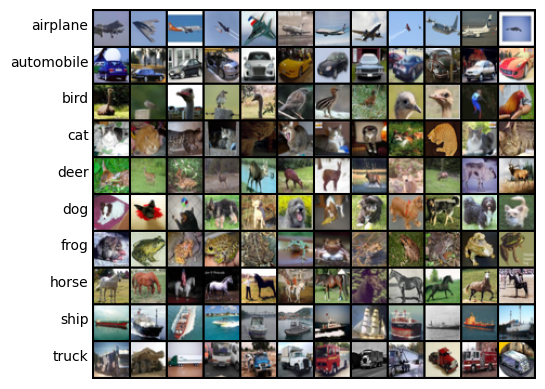

In [100]:
# visualization on train dataset

import random
from torchvision.utils import make_grid

classes = dataset.classes
samples_per_class = 12
samples = []
    
for y, cls in enumerate(classes):
  plt.text(-4, 34 * y + 18, cls, ha='right')
  idxs = (y_train == y).nonzero().view(-1)
  for i in range(samples_per_class):
    idx = idxs[random.randrange(idxs.shape[0])].item()
    samples.append(x_train[idx])
img = make_grid(samples, nrow=samples_per_class)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Subsampling data for experimentation

In [101]:
# x_train = x_train[:500]
# y_train = y_train[:500]

# x_valid = x_valid[:250]
# y_valid = y_valid[:250]

print('Training set:', )
print('  data shape:', x_train.shape)
print('  labels shape: ', y_train.shape)
print('Valid set:')
print('  data shape: ', x_valid.shape)
print('  labels shape', y_valid.shape)

Training set:
  data shape: torch.Size([42500, 3, 32, 32])
  labels shape:  torch.Size([42500])
Valid set:
  data shape:  torch.Size([7500, 3, 32, 32])
  labels shape torch.Size([7500])


## Implementation of KNN

In [102]:
class KnnClassifier:
    def __init__(self, x_train, y_train):
        """
        Create a new K-Nearest Neighbor classifier with the specified training data.
        In the initializer we simply memorize the provided training data.

        Inputs:
        - x_train: Torch tensor of shape (num_train, C, H, W) giving training data
        - y_train: int64 torch tensor of shape (num_train,) giving training labels
        """
        self.x_train = x_train.contiguous()
        self.y_train = y_train.contiguous()
  
    def predict(self, x_test, k=1):
        """
        Make predictions using the classifier.

        Inputs:
        - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
        - k: The number of neighbors to use for predictions

        Returns:
        - y_test_pred: Torch tensor of shape (num_test,) giving predicted labels
            for the test samples.
        """
        
        def compute_dists(x_train, x_test):
            # distances matrix where each row is test example - all train examples
            num_train = self.x_train.shape[0]
            num_test = x_test.shape[0]

            x_train = x_train.reshape(num_train, -1)
            x_test = x_test.reshape(num_test, 1, -1)

            dists = torch.empty(num_test, num_train)

            for i in range(num_test):
                dists[i] = torch.pow(x_test[i] - x_train, 2).sum(dim=-1)
                
            return dists
        
        def predict_labels(dists, y_test, k=1):
            num_test = dists.shape[0]
            y_pred = torch.zeros(num_test, dtype=torch.int64)
            for i in range(num_test):
                _, indices = torch.topk(dists[i], k=k, largest=False)
                neighbor_labels = y_test[indices]
                counts = torch.bincount(neighbor_labels)
                max_counts = torch.max(counts)
                max_labels = torch.nonzero(counts == max_counts).flatten()
                
                if len(max_labels) > 1:
                    y_pred[i] = max_labels.min().item()
                else:
                    y_pred[i] = max_labels.item()
            return y_pred

        dists = compute_dists(self.x_train, x_test.contiguous())
        y_pred = predict_labels(dists, self.y_train, k=k)
        
        return y_pred
  
    def check_accuracy(self, x_test, y_test, k=1, quiet=False):
        """
        Utility method for checking the accuracy of this classifier on test data.
        Returns the accuracy of the classifier on the test data, and also prints a
        message giving the accuracy.

        Inputs:
        - x_test: Torch tensor of shape (num_test, C, H, W) giving test samples
        - y_test: int64 torch tensor of shape (num_test,) giving test labels
        - k: The number of neighbors to use for prediction
        - quiet: If True, don't print a message.

        Returns:
        - accuracy: Accuracy of this classifier on the test data, as a percent.
            Python float in the range [0, 100]
        """
        y_pred = self.predict(x_test, k=k)
        num_samples = x_test.shape[0]
        num_correct = (y_test == y_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        
        msg = (f'Got {num_correct} / {num_samples} correct; Accuracy is {accuracy:.2f}%')
        
        if not quiet:
            print(msg)
            
        return accuracy

In [103]:
model = KnnClassifier(x_train, y_train)

model.check_accuracy(x_valid, y_valid, k=5)

KeyboardInterrupt: 